In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import helper_functions as hf
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, classification_report
import lightgbm as lgb
import my_pipeline as mp
import gc

%matplotlib inline

## Introduction
I will investigate 6 other tables and include them into the main training data to see if I can improve model performance. 
<br>
Then, I will fit lightgbm model to the expanded dataset.

## Bureau and Bureau Balance

In [3]:
bureau = hf.read_file('bureau.csv')
bureau_balance = hf.read_file('bureau_balance.csv')

In [4]:
print(f'bureau: {bureau.shape}')
print(f'bureau_balance: {bureau_balance.shape}')

bureau: (1716428, 17)
bureau_balance: (27299925, 3)


In [5]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [10]:
bureau.isnull().sum()

SK_ID_CURR                      0
SK_ID_BUREAU                    0
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
DAYS_CREDIT_ENDDATE        105553
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_MAX_OVERDUE    1124488
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM                 13
AMT_CREDIT_SUM_DEBT        257669
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                     0
DAYS_CREDIT_UPDATE              0
AMT_ANNUITY               1226791
dtype: int64

In [8]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [28]:
def one_hot_encoding(df, col=None):
    cat_cols = None
    new_df = None
    if col:
        new_df = pd.get_dummies(df, columns=col, drop_first=True)
    else:
        new_df =  pd.get_dummies(df, drop_first=True)
    cat_cols = [col for col in new_df.columns if col not in df.columns]
    return cat_cols, new_df

First, I one hot encoded both data so that aggregation can be done on these two dataset to make bureau ID unqiue.

In [29]:
b_cat_cols, bureau_oh = one_hot_encoding(bureau)
bb_cat_cols, bb_oh = one_hot_encoding(bureau_balance)
print(f'bureau: {bureau_oh.shape}')
print(f'bureau_balance: {bb_oh.shape}')

bureau: (1716428, 34)
bureau_balance: (27299925, 9)


In [56]:
def aggregation(df, base_param, cat_cols, by, name=''):
    if cat_cols:
        for col in cat_cols:
            base_param[col] = ['mean']
    df_agg = df.groupby(by).agg(base_param)
    df_agg.columns = pd.Index([name + e[0] + "_" + e[1].upper() for e in df_agg.columns.tolist()])
    return df_agg

In [44]:
bb_oh_agg_param = {'MONTHS_BALANCE': ['min', 'max', 'size']}
bb_oh_agg = aggregation(bb_oh, bb_oh_agg_param, bb_cat_cols, 'SK_ID_BUREAU')

Second, I joined the aggregated bureau_balance data with bureau data on bureau ID and further aggregate the joined dataset to make the main applicants ID unqiue.

In [46]:
bureau_joined = bureau_oh.join(bb_oh_agg, how='left', on='SK_ID_BUREAU')
bureau_joined.drop(['SK_ID_BUREAU'], axis=1, inplace= True)

In [49]:
def aggregation2(df, base_param, cat_param, by, name=''):
    df_agg = df.groupby(by).agg({**base_param, **cat_param})
    df_agg.columns = pd.Index([name + e[0] + "_" + e[1].upper() for e in df_agg.columns.tolist()])
    return df_agg

In [53]:
bureau_oh_agg_param = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}
cat_agg_param = {}
for col in b_cat_cols: cat_agg_param[col] = ['mean']
for col in bb_cat_cols: cat_agg_param[col + "_MEAN"] = ['mean']

bureau_agg = aggregation2(bureau_joined, bureau_oh_agg_param, cat_agg_param, 'SK_ID_CURR', 'BURO_')

Third, I aggregate based on 3 credit activities: active, closed and sold

In [57]:
# Bureau: Active credits
active = bureau_joined[(bureau_joined['CREDIT_ACTIVE_Closed'] == 0) & (bureau_joined['CREDIT_ACTIVE_Sold'] == 0)]
active_agg = aggregation(active, bureau_oh_agg_param, None, 'SK_ID_CURR', 'ACTIVE_')
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')

In [60]:
# Bureau: Closed credits
closed = bureau_joined[bureau_joined['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = aggregation(closed, bureau_oh_agg_param, None, 'SK_ID_CURR', 'CLOSED_')
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

In [61]:
# Bureau: Sold credits
sold = bureau_joined[bureau_joined['CREDIT_ACTIVE_Sold'] == 1]
sold_agg = aggregation(sold, bureau_oh_agg_param, None, 'SK_ID_CURR', 'SOLD_')
bureau_agg = bureau_agg.join(sold_agg, how='left', on='SK_ID_CURR')

In [66]:
bureau_agg.head()

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,SOLD_AMT_CREDIT_SUM_OVERDUE_MEAN,SOLD_AMT_CREDIT_SUM_LIMIT_MEAN,SOLD_AMT_CREDIT_SUM_LIMIT_SUM,SOLD_AMT_ANNUITY_MAX,SOLD_AMT_ANNUITY_MEAN,SOLD_CNT_CREDIT_PROLONG_SUM,SOLD_MONTHS_BALANCE_MIN_MIN,SOLD_MONTHS_BALANCE_MAX_MAX,SOLD_MONTHS_BALANCE_SIZE_MEAN,SOLD_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Previous Applications

In [67]:
previous_application = hf.read_file('previous_application.csv')

In [68]:
print(f'previous_application: {previous_application.shape}')
previous_application.head()

previous_application: (1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
previous_application.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,...,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1.923089e+06,2.783572e+05,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,...,0.773503,-8.806797e+02,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,3.334028e+00,5.932963e-02,0.107823,...,0.100879,7.790997e+02,7.127443e+03,1.456729e+01,88916.115834,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,...,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,1.000000e+00,0.000000,...,0.715645,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,1.000000e+00,0.051605,...,0.835095,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,1.000000e+00,0.108909,...,0.852537,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000
max,2.845382e+06,4.562550e+05,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000e+00,1.000000,...,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


Notice, the anomaly 365243 appears again in 'Days' related features.

In [73]:
prev_cat_cols, prev_oh= one_hot_encoding(previous_application)
prev_oh['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev_oh['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev_oh['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev_oh['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev_oh['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

In [77]:
prev_agg_param = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
}
prev_cat_agg_param = {}
for col in prev_cat_cols:
    prev_cat_agg_param[col] = ['mean']

prev_agg = aggregation2(prev_oh, prev_agg_param, prev_cat_agg_param, 'SK_ID_CURR', 'PREV')

## Credit Card Balance

In [79]:
credit_card_balance = hf.read_file('credit_card_balance.csv')

In [80]:
print(f'credit_card_balance: {credit_card_balance.shape}')
credit_card_balance.head()

credit_card_balance: (3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [81]:
ccb_cat_cols, ccb_oh= one_hot_encoding(credit_card_balance)

In [82]:
ccb_oh.drop(['SK_ID_PREV'], axis= 1, inplace = True)
ccb_agg = ccb_oh.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
ccb_agg.columns = pd.Index(['CCB_' + e[0] + "_" + e[1].upper() for e in ccb_agg.columns.tolist()])
ccb_agg['CC_COUNT'] = ccb_oh.groupby('SK_ID_CURR').size()

In [83]:
ccb_agg.head()

,CCB_MONTHS_BALANCE_MIN,CCB_MONTHS_BALANCE_MAX,CCB_MONTHS_BALANCE_MEAN,CCB_MONTHS_BALANCE_SUM,CCB_MONTHS_BALANCE_VAR,CCB_AMT_BALANCE_MIN,CCB_AMT_BALANCE_MAX,CCB_AMT_BALANCE_MEAN,CCB_AMT_BALANCE_SUM,CCB_AMT_BALANCE_VAR,...,CCB_NAME_CONTRACT_STATUS_Sent proposal_MAX,CCB_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CCB_NAME_CONTRACT_STATUS_Sent proposal_SUM,CCB_NAME_CONTRACT_STATUS_Sent proposal_VAR,CCB_NAME_CONTRACT_STATUS_Signed_MIN,CCB_NAME_CONTRACT_STATUS_Signed_MAX,CCB_NAME_CONTRACT_STATUS_Signed_MEAN,CCB_NAME_CONTRACT_STATUS_Signed_SUM,CCB_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-6,-1,-3.5,-21,3.5,0.0,0.00,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0.0,0,0.0,6
100011,-75,-2,-38.5,-2849,462.5,0.0,189000.00,54482.111149,4031676.225,4.641321e+09,...,0,0.0,0,0.0,0,0,0.0,0,0.0,74
100013,-96,-1,-48.5,-4656,776.0,0.0,161420.22,18159.919219,1743352.245,1.869473e+09,...,0,0.0,0,0.0,0,0,0.0,0,0.0,96
100021,-18,-2,-10.0,-170,25.5,0.0,0.00,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0.0,0,0.0,17
100023,-11,-4,-7.5,-60,6.0,0.0,0.00,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0.0,0,0.0,8


## Installments Payments

In [87]:
installments_payments = hf.read_file('installments_payments.csv')

In [88]:
print(f'credit_card_balance: {installments_payments.shape}')
installments_payments.head()

credit_card_balance: (13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [89]:
ip_cat_cols, ip_oh= one_hot_encoding(installments_payments)

In [90]:
ip_oh['PAYMENT_PERC'] = ip_oh['AMT_PAYMENT'] / ip_oh['AMT_INSTALMENT']
ip_oh['PAYMENT_DIFF'] = ip_oh['AMT_INSTALMENT'] - ip_oh['AMT_PAYMENT']
ip_oh['DPD'] = ip_oh['DAYS_ENTRY_PAYMENT'] - ip_oh['DAYS_INSTALMENT']
ip_oh['DBD'] = ip_oh['DAYS_INSTALMENT'] - ip_oh['DAYS_ENTRY_PAYMENT']
ip_oh['DPD'] = ip_oh['DPD'].apply(lambda x: x if x > 0 else 0)
ip_oh['DBD'] = ip_oh['DBD'].apply(lambda x: x if x > 0 else 0)

In [101]:
ip_oh_agg_param = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max', 'mean', 'sum'],
    'DBD': ['max', 'mean', 'sum'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
}
ip_agg = aggregation(ip_oh, ip_oh_agg_param, ip_cat_cols, 'SK_ID_CURR', 'IP')
ip_agg['INSTAL_COUNT'] = ip_oh.groupby('SK_ID_CURR').size()

In [105]:
ip_agg.head()

,IPNUM_INSTALMENT_VERSION_NUNIQUE,IPDPD_MAX,IPDPD_MEAN,IPDPD_SUM,IPDBD_MAX,IPDBD_MEAN,IPDBD_SUM,IPPAYMENT_PERC_MAX,IPPAYMENT_PERC_MEAN,IPPAYMENT_PERC_SUM,...,IPAMT_INSTALMENT_MEAN,IPAMT_INSTALMENT_SUM,IPAMT_PAYMENT_MIN,IPAMT_PAYMENT_MAX,IPAMT_PAYMENT_MEAN,IPAMT_PAYMENT_SUM,IPDAYS_ENTRY_PAYMENT_MAX,IPDAYS_ENTRY_PAYMENT_MEAN,IPDAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,2,11.0,1.571429,11.0,36.0,8.857143,62.0,1.0,1.0,7.0,...,5885.132143,41195.925,3951.000,17397.900,5885.132143,41195.925,-1628.0,-2195.000000,-15365.0,7
100002,2,0.0,0.000000,0.0,31.0,20.421053,388.0,1.0,1.0,19.0,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19
100003,2,0.0,0.000000,0.0,14.0,7.160000,179.0,1.0,1.0,25.0,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25
100004,2,0.0,0.000000,0.0,11.0,7.666667,23.0,1.0,1.0,3.0,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3
100005,2,1.0,0.111111,1.0,37.0,23.666667,213.0,1.0,1.0,9.0,...,6240.205000,56161.845,4813.200,17656.245,6240.205000,56161.845,-470.0,-609.555556,-5486.0,9


## POS Cash Balance

In [95]:
POS_CASH_balance = hf.read_file('POS_CASH_balance.csv')
print(f'POS_CASH_balance: {POS_CASH_balance.shape}')
POS_CASH_balance.head()

POS_CASH_balance: (10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [96]:
pcb_cat_cols, pcb_oh= one_hot_encoding(POS_CASH_balance)

In [103]:
pcb_agg_param = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
pcb_agg = aggregation(pcb_oh, pcb_agg_param, pcb_cat_cols, 'SK_ID_CURR', 'PCB')
pcb_agg['PCB_COUNT'] = pcb_oh.groupby('SK_ID_CURR').size()

In [104]:
pcb_agg.head()

,PCBMONTHS_BALANCE_MAX,PCBMONTHS_BALANCE_MEAN,PCBMONTHS_BALANCE_SIZE,PCBSK_DPD_MAX,PCBSK_DPD_MEAN,PCBSK_DPD_DEF_MAX,PCBSK_DPD_DEF_MEAN,PCBNAME_CONTRACT_STATUS_Amortized debt_MEAN,PCBNAME_CONTRACT_STATUS_Approved_MEAN,PCBNAME_CONTRACT_STATUS_Canceled_MEAN,PCBNAME_CONTRACT_STATUS_Completed_MEAN,PCBNAME_CONTRACT_STATUS_Demand_MEAN,PCBNAME_CONTRACT_STATUS_Returned to the store_MEAN,PCBNAME_CONTRACT_STATUS_Signed_MEAN,PCBNAME_CONTRACT_STATUS_XNA_MEAN,PCB_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,
100001,-53,-72.555556,9,7,0.777778,7,0.777778,0.0,0.0,0.0,0.222222,0.0,0.0,0.000000,0.0,9
100002,-1,-10.000000,19,0,0.000000,0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,19
100003,-18,-43.785714,28,0,0.000000,0,0.000000,0.0,0.0,0.0,0.071429,0.0,0.0,0.000000,0.0,28
100004,-24,-25.500000,4,0,0.000000,0,0.000000,0.0,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0,4
100005,-15,-20.000000,11,0,0.000000,0,0.000000,0.0,0.0,0.0,0.090909,0.0,0.0,0.090909,0.0,11


## Merge All Dataset

In [99]:
application_new, application_features_new, application_label_new = hf.load_application_new()

In [106]:
data_full = application_new.join(bureau_agg, how='left', on='SK_ID_CURR')
data_full = data_full.join(prev_agg, how='left', on='SK_ID_CURR')
data_full = data_full.join(ccb_agg, how='left', on='SK_ID_CURR')
data_full = data_full.join(ip_agg, how='left', on='SK_ID_CURR')
data_full = data_full.join(pcb_agg, how='left', on='SK_ID_CURR')

In [115]:
data_full.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,PCBSK_DPD_DEF_MEAN,PCBNAME_CONTRACT_STATUS_Amortized debt_MEAN,PCBNAME_CONTRACT_STATUS_Approved_MEAN,PCBNAME_CONTRACT_STATUS_Canceled_MEAN,PCBNAME_CONTRACT_STATUS_Completed_MEAN,PCBNAME_CONTRACT_STATUS_Demand_MEAN,PCBNAME_CONTRACT_STATUS_Returned to the store_MEAN,PCBNAME_CONTRACT_STATUS_Signed_MEAN,PCBNAME_CONTRACT_STATUS_XNA_MEAN,PCB_COUNT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,19.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.071429,0.0,0.000000,0.000000,0.0,28.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.250000,0.0,0.000000,0.000000,0.0,4.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.095238,0.0,0.047619,0.000000,0.0,21.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.045455,0.0,0.000000,0.015152,0.0,66.0


## LightGBM

In [2]:
with hf.timer('Preparing Training Data'):
    X_train, X_test, y_train, y_test = mp.prepare_for_training()

application loaded (307511, 237)
bureau loaded (305811, 135)
previous_applications loaded (338857, 153)
credit_card_balance loaded (103558, 131)
installments_payments loaded (339587, 26)
POS_CASH_balance loaded (337252, 16)
All data merged (307511, 698)
Load Full Dataset - done in 131s
Training size: (246008, 696)
Testing size: (61503, 696)
Preparing Training Data - done in 136s


In [10]:
lgb_param = {'num_leaves': 34, 
             'n_estimators': 10000, 
             'learning_rate': 0.02, 
             'colsample_bytree': 0.95, 
             'subsample': 0.87, 
             'max_depth': 8, 
             'reg_alpha': 0.04, 
             'reg_lambda': 0.07, 
             'min_split_gain': 0.02, 
             'min_child_weight': 39, 
             'class_weight': 'balanced'}
lgb_model = lgb.cv(lgb_param, train_set=lgb.Dataset(X_train, y_train), nfold=10, metrics='auc', verbose_eval=200, 
              early_stopping_rounds=200, eval_train_metric=True)

E:\Programming\Anaconda3\37\lib\site-packages\lightgbm\engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's train auc: 0.795476 + 0.000392614	cv_agg's valid auc: 0.771476 + 0.00571176
[400]	cv_agg's train auc: 0.818627 + 0.000351603	cv_agg's valid auc: 0.780153 + 0.0051958
[600]	cv_agg's train auc: 0.835433 + 0.000367561	cv_agg's valid auc: 0.783202 + 0.004898
[800]	cv_agg's train auc: 0.849036 + 0.000367967	cv_agg's valid auc: 0.784208 + 0.00470191
[1000]	cv_agg's train auc: 0.860724 + 0.000482112	cv_agg's valid auc: 0.784449 + 0.00450123
[1200]	cv_agg's train auc: 0.871099 + 0.000431933	cv_agg's valid auc: 0.784636 + 0.0045513
[1400]	cv_agg's train auc: 0.880175 + 0.000370499	cv_agg's valid auc: 0.784534 + 0.00475271


In [18]:
lgb_model.keys()

dict_keys(['train auc-mean', 'train auc-stdv', 'valid auc-mean', 'valid auc-stdv'])

In [45]:
def display_learning_curve(eval_history, title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_scores_mean = np.array(eval_history['train auc-mean'])
    train_scores_std = np.array(eval_history['train auc-stdv'])
    valid_scores_mean = np.array(eval_history['valid auc-mean'])
    valid_scores_std = np.array(eval_history['valid auc-stdv'])
    train_sizes = range(len(train_scores_mean))
    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                         valid_scores_mean + valid_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, '-', color="r",
                 label="Training ROC")
    plt.plot(train_sizes, valid_scores_mean, '-', color="g",
                 label="Cross-validation ROC")
    plt.legend(loc="best")
    
    print(f'Validation ROC: {np.max(valid_scores_mean)}')

    return plt

Validation ROC: 0.7846364519529223


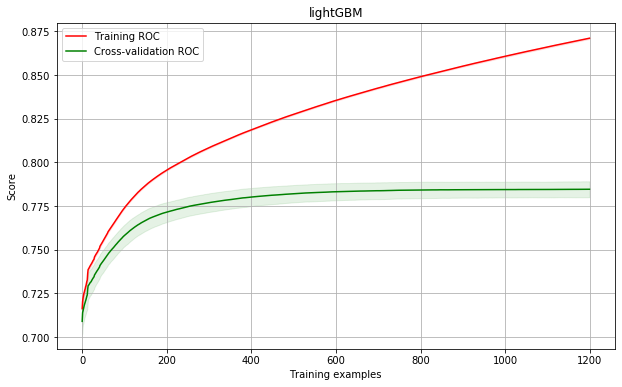

In [46]:
display_learning_curve(lgb_model, 'lightGBM')
plt.show()

In [92]:
def kfold_lightgbm(lgb_clf, X_train, y_train, X_test, num_folds):
    print(f"Starting LightGBM. Train shape: {X_train.shape}, test shape: {X_test.shape}")
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=555)
    feature_importance_df = pd.DataFrame()
    feat_name = X_train.columns
    eval_dict = []
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
        train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

        lgb_clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                                  eval_metric='auc', verbose=200, early_stopping_rounds=200)
        eval_dict.append(lgb_clf.evals_result_)
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feat_name
        fold_importance_df["importance"] = lgb_clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        del train_x, train_y, valid_x, valid_y
        gc.collect()
    
    feature_importance_df = feature_importance_df[["feature", "importance"]].groupby("feature", as_index=False).mean().sort_values("importance", ascending=False)
    saved = joblib.dump(lgb_clf, f'Models/lgb.md')
    print(f'Model saved as {saved}')
    return lgb_clf, feature_importance_df, eval_dict

In [93]:
lgb_m = lgb.LGBMClassifier(num_leaves=34, 
                           n_estimators=10000, 
                           learning_rate=0.02, 
                           colsample_bytree=0.95, 
                           subsample=0.87, 
                           max_depth=8, 
                           reg_alpha=0.04, 
                           reg_lambda=0.07, 
                           min_split_gain=0.02, 
                           min_child_weight=39, 
                           class_weight='balanced',)

In [94]:
with hf.timer('Fitting LightGBM'):
    lgb_clf, feature_importance_df, eval_hist = kfold_lightgbm(lgb_m, X_train, y_train, 10)

Starting LightGBM. Train shape: (246008, 696), test shape: (61503, 696)
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.803317	training's binary_logloss: 0.550366	valid_1's auc: 0.775626	valid_1's binary_logloss: 0.559709
[400]	training's auc: 0.830416	training's binary_logloss: 0.516737	valid_1's auc: 0.785326	valid_1's binary_logloss: 0.534497
[600]	training's auc: 0.849373	training's binary_logloss: 0.494378	valid_1's auc: 0.787228	valid_1's binary_logloss: 0.519797
[800]	training's auc: 0.865107	training's binary_logloss: 0.476199	valid_1's auc: 0.787883	valid_1's binary_logloss: 0.508258
[1000]	training's auc: 0.878516	training's binary_logloss: 0.460201	valid_1's auc: 0.787737	valid_1's binary_logloss: 0.498302
Early stopping, best iteration is:
[869]	training's auc: 0.86996	training's binary_logloss: 0.470506	valid_1's auc: 0.787919	valid_1's binary_logloss: 0.504649
Training until validation scores don't improve for 200 rounds
[200]	trainin

[400]	training's auc: 0.83111	training's binary_logloss: 0.515988	valid_1's auc: 0.777647	valid_1's binary_logloss: 0.537524
[600]	training's auc: 0.85021	training's binary_logloss: 0.493475	valid_1's auc: 0.780448	valid_1's binary_logloss: 0.522928
[800]	training's auc: 0.865676	training's binary_logloss: 0.475339	valid_1's auc: 0.780763	valid_1's binary_logloss: 0.511496
Early stopping, best iteration is:
[705]	training's auc: 0.858717	training's binary_logloss: 0.483519	valid_1's auc: 0.780864	valid_1's binary_logloss: 0.516517
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.8033	training's binary_logloss: 0.550559	valid_1's auc: 0.778074	valid_1's binary_logloss: 0.558215
[400]	training's auc: 0.830551	training's binary_logloss: 0.516815	valid_1's auc: 0.788729	valid_1's binary_logloss: 0.532912
[600]	training's auc: 0.849414	training's binary_logloss: 0.49442	valid_1's auc: 0.792244	valid_1's binary_logloss: 0.518141
[800]	training's auc: 0.86

In [95]:
def plot_importances(feature_importance_df, title):
    plt.figure(figsize=(10, 8))
    sns.barplot(x="importance", y="feature", data=feature_importance_df[:40])
    plt.title(title)
    plt.tight_layout()
    plt.show()

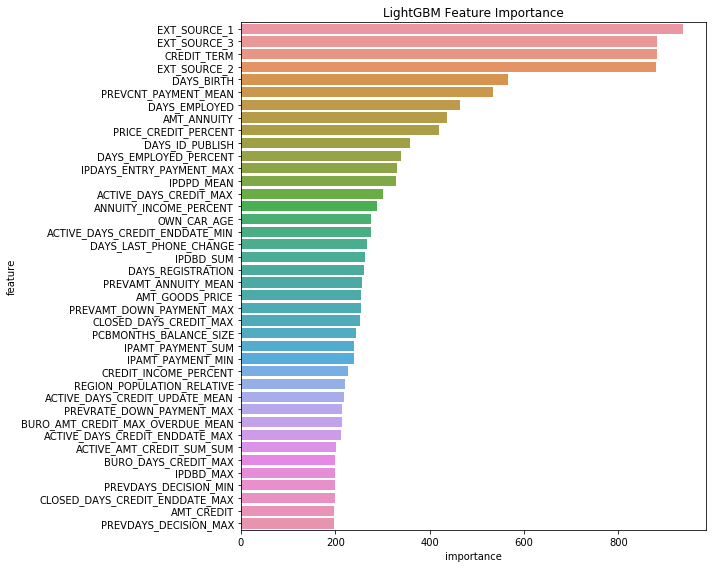

In [96]:
plot_importances(feature_importance_df, 'LightGBM Feature Importance')

In [98]:
def evaluate_model(model, X_test, y_test):
    print(f'{model}\n')
    y_predict = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_predict)
    cr = classification_report(y_test, y_predict, target_names=['Repaid', 'Default'], digits=3)
    print('Out-of-Sample Performance:\n')
    print(cr)
    print(f'roc_auc: {roc_auc}\n')
    print(f'Confusion Matrix:\n')
    plot_confusion_matrix(model, X_test, y_test)
    plt.show()

LGBMClassifier(class_weight='balanced', colsample_bytree=0.95,
               learning_rate=0.02, max_depth=8, min_child_weight=39,
               min_split_gain=0.02, n_estimators=10000, num_leaves=34,
               reg_alpha=0.04, reg_lambda=0.07, subsample=0.87)

Out-of-Sample Performance:

              precision    recall  f1-score   support

      Repaid      0.960     0.775     0.858     56450
     Default      0.204     0.644     0.309      5053

    accuracy                          0.764     61503
   macro avg      0.582     0.709     0.583     61503
weighted avg      0.898     0.764     0.813     61503

roc_auc: 0.7092588605073205

Confusion Matrix:



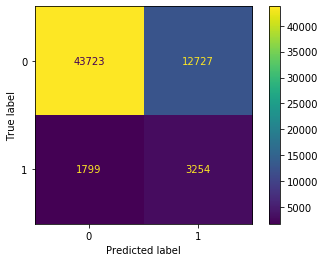

In [99]:
evaluate_model(lgb_clf, X_test, y_test)